# 1. ENVIRONMENT & DATA LOADING

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
sns.set_theme()
RANDOM_STATE = 1776
print("Numpy Version: " + np.__version__)
print("Pandas Version: " + pd.__version__)
print("Seaborn Version: " + sns.__version__)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

Numpy Version: 2.3.4
Pandas Version: 2.3.3
Seaborn Version: 0.13.2


In [3]:
df = pd.read_csv('../data/engineered_data.csv')
df.head()

,belongs_to_collection,budget,genres,homepage,id,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,title,vote_average,vote_count,cast,return,year,cast_size,crew_size,director,is_Animation,is_Comedy,is_Family,is_Adventure,is_Fantasy,is_Romance,is_Drama,is_Action,is_Crime,is_Thriller,is_Horror,is_History,is_Science Fiction,is_Mystery,is_War,is_Foreign,is_Music,is_Documentary,is_Western,is_TV Movie,is_english,is_Friday,is_Holiday
0,1,30000000.0,3,1,862,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,1,1,1995-10-30,373554033.0,81.0,1,NaN,Toy Story,7.7,5415.0,"['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim...",12.451801,1995.0,13,106,John Lasseter,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,65000000.0,3,1,8844,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,3,1,1995-12-15,262797249.0,104.0,2,Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,"['Robin Williams', 'Jonathan Hyde', 'Kirsten D...",4.043035,1995.0,26,16,NaN,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
2,1,NaN,2,1,15602,A family wedding reignites the ancient feud be...,11.712900,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,2,1,1995-12-22,NaN,101.0,1,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92.0,"['Walter Matthau', 'Jack Lemmon', 'Ann-Margret...",NaN,1995.0,7,4,Howard Deutch,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
3,0,16000000.0,3,1,31357,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,1,1,1995-12-22,81452156.0,127.0,1,Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34.0,"['Whitney Houston', 'Angela Bassett', 'Loretta...",5.090760,1995.0,10,10,Forest Whitaker,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
4,1,NaN,1,1,11862,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,2,1,1995-02-10,76578911.0,106.0,1,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173.0,"['Steve Martin', 'Diane Keaton', 'Martin Short...",NaN,1995.0,12,7,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0


# 2. USER FUNCTIONS

In [4]:
def get_quarter(date_str):
    """
    Determine the quarter from month of the date
    """
    if pd.isna(date_str):
        return np.nan
    else:
        date = datetime.strptime(date_str, '%Y-%m-%d')
        quarter = (date.month - 1) // 3 + 1
        return int(quarter)


def labelClass(ratioValue):
    """
    Catorgorized ration value in return feature
    Class: 0 = False
    Class: 1 = True
    """
    if ratioValue <= 1:
        return 0
    elif ratioValue > 1:
        return 1
    else:
        return np.nan


def Curve(models, X, y):
    """
    Helper function top plot multiple Models ROC Curves.
    """
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    
    for m in models:
        model = m['model']
        # Check if the model is fitted
        if not hasattr(model, "classes_"):
             print(f"Model {m['label']} is not fitted. Skipping.")
             continue
            
        y_pred = model.predict(X)
        y_hat = model.predict_proba(X)
        average_precision = metrics.average_precision_score(y, y_hat[:,1])
        precision, recall, thresholds = metrics.precision_recall_curve(y, y_hat[:,1])
        fscore = (2 * precision * recall) / (precision + recall)
        # Handle potential NaN in fscore
        fscore = np.nan_to_num(fscore)
        ix = np.argmax(fscore)
        
        if ix < len(thresholds):
            print('\t\t\t\t\t\t\t\t\t\t\t' + 'Model=%s Best Threshold=%.3f, F-Score=%.3f' % (m['label'],thresholds[ix], fscore[ix]))
        else:
             print('\t\t\t\t\t\t\t\t\t\t\t' + 'Model=%s F-Score=%.3f' % (m['label'], fscore[ix]))

        bestlabel = 'Best for ' + m['label']
        
        fpr, tpr, thresholds_roc = metrics.roc_curve(y, model.predict_proba(X)[:,1])
        auc = metrics.roc_auc_score(y , model.predict(X))
        axs[0].plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
        axs[1].plot(recall, precision, label='%s Avg. prec. (area = %0.2f)' % (m['label'], average_precision))
        axs[1].scatter(recall[ix], precision[ix], marker=m['marker'], label=bestlabel)
        
    axs[0].plot([0, 1], [0, 1],'r--',label='No Skill')
    axs[0].set_ylim([0.0, 1.05])
    axs[0].set_xlabel('1-Specificity(False Positive Rate)')
    axs[0].set_ylabel('Sensitivity(True Positive Rate)')
    axs[0].set_title('Receiver Operating Characteristic')
    axs[0].legend(loc="lower right")

    axs[1].set_ylim([0.0, 1.05])
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].set_title('Precision Recall Curves')
    axs[1].legend(loc="lower left")
    plt.show()


def plotBar(df_, stage=0):
    """
    Help function for Bar Plots of Balanced Accuracy & F-1 Scores
    """
    df = df_.copy()
    df.reset_index(inplace=True)
    df.sort_values(by=['Algorithm'], inplace=True)

    if stage == 0:
        str_title = 'Base Models'
        df1 = df[~df.Algorithm.str.contains("-")].copy()
        df2 = df[~df.Algorithm.str.contains("-")].copy()
    elif stage == 2:
        str_title = 'Over Sampling'
        df1 = df[df.Algorithm.str.contains("-Over")].copy()
        df1['Algorithm'] = df1['Algorithm'].apply(lambda x: x.split('-')[0])
        df2 = df[df.Algorithm.str.contains("-Over")].copy()
        df2['Algorithm'] = df2['Algorithm'].apply(lambda x: x.split('-')[0])
    else: # stage == 3
        str_title = 'Under Sampling'
        df1 = df[df.Algorithm.str.contains("-Under")].copy()
        df1['Algorithm'] = df1['Algorithm'].apply(lambda x: x.split('-')[0])
        df2 = df[df.Algorithm.str.contains("-Under")].copy()
        df2['Algorithm'] = df2['Algorithm'].apply(lambda x: x.split('-')[0])
   
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    
    bar_width = 0.35
    positions1 = np.arange(len(df1))
    positions2 = np.arange(len(df2))
    
    axs[0].bar(positions1 - bar_width/2, df1['Balanced Accuracy Train'], bar_width, label='Balanced Accuracy Train')
    axs[0].bar(positions1 + bar_width/2, df1['Balanced Accuracy Test'], bar_width, label='Balanced Accuracy Test')
    
    axs[1].bar(positions2 - bar_width/2, df2['F1 Train'], bar_width, label='F1 Accuracy Train')
    axs[1].bar(positions2 + bar_width/2, df2['F1 Test'], bar_width, label='F1 Accuracy Test')
    
    axs[0].set_xlabel('Algorithm')
    axs[0].set_ylabel('Balanced Accuracy')
    axs[0].set_title(f"Comparison of \nBalanced Accuracy Train and Test\n{str_title}")
    axs[0].set_yticks(np.arange(0.0, 1.1, 0.1))
    axs[0].set_xticks(positions1)
    axs[0].set_xticklabels(df1['Algorithm'], rotation=45, ha='right')
    axs[0].legend()
    
    axs[1].set_xlabel('Algorithm')
    axs[1].set_ylabel('F1 Accuracy')
    axs[1].set_title(f"Comparison of \nF-1 Accuracy Train and Test\n{str_title}")
    axs[1].set_yticks(np.arange(0.0, 1.1, 0.1))
    axs[1].set_xticks(positions2)
    axs[1].set_xticklabels(df2['Algorithm'], rotation=45, ha='right')
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()

In [5]:
def calculate_classifier_metrics(model, X, y):
    """
    Calculates classification metrics.
    Returns: (recall, specificity, precision, balanced_accuracy, f1_score)
    """
    pred = model.predict(X)
    
    try:
        tn, fp, fn, tp = metrics.confusion_matrix(y, pred).ravel()
    except ValueError:
        # This can happen if y contains only one class
        print(f"Warning: Could not compute confusion matrix. Unique y values: {np.unique(y)}")
        tn, fp, fn, tp = 0, 0, 0, 0
        if np.all(y == 0):
            tn = len(y)
        elif np.all(y == 1):
            tp = len(y)
                                       
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    balanced_accuracy = 0.5 * (specificity + recall)
    f1_score  = 2 * ((precision * recall) / (precision + recall)) if (precision + recall) > 0 else 0
    
    return recall, specificity, precision, balanced_accuracy, f1_score

def plot_confusion_matrix(model, X_train, y_train, X_test, y_test, scenario_name=""):
    """
    Plots the Train and Test confusion matrices side-by-side for a given model.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6)) # 1 row, 2 columns

    # Get model display name
    model_name = type(model).__name__
    if "RandomForest" in model_name:
        model_display_name = "RandomForest"
    elif "LogisticRegression" in model_name:
        model_display_name = "LogisticRegression"
    else:
        model_display_name = model_name
    
    try:
        pred_train = model.predict(X_train)
        cm_train = metrics.confusion_matrix(y_train, pred_train, labels=model.classes_)
        disp_train = metrics.ConfusionMatrixDisplay(cm_train, display_labels=model.classes_)
        
        disp_train.plot(ax=axes[0], cmap='Blues', values_format='d', colorbar=False)
        axes[0].set_title(f"{model_display_name} ({scenario_name} Train)", fontsize=16)
        axes[0].grid(False)
    except Exception as e:
        axes[0].set_title(f"{model_display_name} ({scenario_name} Train) - Error", fontsize=16)
        axes[0].text(0.5, 0.5, f"Could not plot: {e}", horizontalalignment='center', verticalalignment='center', transform=axes[0].transAxes)

    try:
        pred_test = model.predict(X_test)
        cm_test = metrics.confusion_matrix(y_test, pred_test, labels=model.classes_)
        disp_test = metrics.ConfusionMatrixDisplay(cm_test, display_labels=model.classes_)
        
        disp_test.plot(ax=axes[1], cmap='Blues', values_format='d', colorbar=False)
        axes[1].set_title(f"{model_display_name} (Test)", fontsize=16)
        axes[1].grid(False)
    except Exception as e:
        axes[1].set_title(f"{model_display_name} (Test) - Error", fontsize=16)
        axes[1].text(0.5, 0.5, f"Could not plot: {e}", horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes)

    plt.tight_layout()
    plt.show()
    print("\n")

def kfold_grid(model, parameters, X_train, y_train, score = 'roc_auc'):
    """
    Ten fold CV Stratified
    """
    cv = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
    GSC_estimator = GridSearchCV(model, parameters, scoring=score, cv=cv, n_jobs=-1, error_score='raise')
    
    print("Starting GridSearchCV...")
    fit = GSC_estimator.fit(X_train, y_train)
    
    print("Evaluating best estimator with cross_val_score...")
    scores = cross_val_score(fit.best_estimator_, X=X_train, y=y_train, scoring=score, cv=cv, n_jobs=-1)
    
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
    
    return fit


def plot_feature_importance(model, df):
    """
    Plot feature importance from the model
    Order List & Bar Plot of Importance
    """
    # Check if model has feature_importances_ (e.g., Tree-based models)
    if hasattr(model, 'feature_importances_'):
        df_feat = pd.DataFrame(model.feature_importances_ * 100, index=X.columns, columns=["% Feature Importance"])
    # Check if model has coef_ (e.g., Logistic Regression)
    elif hasattr(model, 'coef_'):
        # Use absolute value of coefficients for importance
        df_feat = pd.DataFrame(np.abs(model.coef_[0]) * 100, index=X.columns, columns=["% Feature Importance (Abs Coef)"])
    else:
        print(f"Model {model.__class__.__name__} does not have 'feature_importances_' or 'coef_' attribute.")
        return

    print(df_feat.sort_values(df_feat.columns[0], axis=0, ascending=False))
    
    # Sort for plotting
    df_feat_sorted = df_feat.sort_values(df_feat.columns[0], axis=0, ascending=False)
    
    # bar plot
    plt.figure(figsize=(10,5))
    ax = sns.barplot(data=df_feat_sorted, y=df_feat_sorted.index, x = df_feat_sorted.iloc[:, 0], orient= 'h')
    ax.set_title(f"{model.__class__.__name__} - Feature Importance", fontsize = 15)
    plt.grid(axis='x', linestyle='--')
    plt.show()
    
    
def classifier_performance_dict(ML, model, X_train, y_train, X_val, y_val):
    """
    Use the helper function to populate the dictionary with 
    performance metrics. (No plotting/printing)
    """
    prediction_info = {"Algorithm" : [],
               "Model Name" : [],
               "Model Parameters": [],
               "Recall(Sensitivity) Train": [],
               "Specificity Train": [],
               "Precision Train": [],
               "Balanced Accuracy Train": [],
               "F1 Train": [],
               "Recall(Sensitivity) Test": [],
               "Specificity Test": [],
               "Precision Test": [],
               "Balanced Accuracy Test": [],
               "F1 Test": [],
              }
    
    keys = ["Algorithm", "Model Name", "Model Parameters", "Recall(Sensitivity) Train",  "Specificity Train", \
            "Precision Train", "Balanced Accuracy Train", "F1 Train", "Recall(Sensitivity) Test", \
            "Specificity Test", "Precision Test", "Balanced Accuracy Test", "F1 Test"]
    
    ML_info = model.get_params()

    # Calculate metrics using the new helper function
    recall_train, spec_train, prec_train, ba_train, f1_train = calculate_classifier_metrics(model, X_train, y_train)
    recall_val, spec_val, prec_val, ba_val, f1_val = calculate_classifier_metrics(model, X_val, y_val)

    data = [ML, model, ML_info, recall_train, spec_train, prec_train, ba_train, f1_train, \
            recall_val, spec_val, prec_val, ba_val, f1_val]

    for key, data_item in zip(keys,data):
        prediction_info[key].append(data_item)
        
    df = pd.DataFrame(prediction_info)
    df.set_index('Algorithm', inplace=True)
    
    return df

In [6]:
# empty dataframe for performance
classify_performance_df = pd.DataFrame()

# 3. DATA PREPROCESSING

In [7]:
df['release_quarter'] = df['release_date'].apply(get_quarter)
df['label'] = df['return'].apply(labelClass)
print("Label counts (including NaN):")
print(df.label.value_counts(dropna=False))

Label counts (including NaN):
label
NaN    40136
1.0     3764
0.0     1629
Name: count, dtype: int64


In [8]:
# remove all the NaN label
df_clean = df[df['label'].isin([True,False])].copy()
print("\ndf_clean info:")
df_clean.info()


df_clean info:
<class 'pandas.core.frame.DataFrame'>
Index: 5393 entries, 0 to 45485
Data columns (total 49 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   belongs_to_collection  5393 non-null   int64  
 1   budget                 5393 non-null   float64
 2   genres                 5393 non-null   int64  
 3   homepage               5393 non-null   int64  
 4   id                     5393 non-null   int64  
 5   overview               5382 non-null   object 
 6   popularity             5393 non-null   float64
 7   poster_path            5393 non-null   object 
 8   production_companies   5393 non-null   int64  
 9   production_countries   5393 non-null   int64  
 10  release_date           5393 non-null   object 
 11  revenue                5393 non-null   float64
 12  runtime                5393 non-null   float64
 13  spoken_languages       5393 non-null   int64  
 14  tagline                4637 non-null   objec

In [9]:
# include features
columnsIncldue = ['belongs_to_collection', 'popularity', 'genres', 'production_companies', 'production_countries', 'runtime', 'spoken_languages', \
                  'cast_size', 'crew_size', 'vote_count', 'is_english', 'is_Friday', 'is_Holiday', 'release_quarter', 'budget', 'label']

clean = df_clean.copy()
clean = clean[columnsIncldue]

In [10]:
# Drop any rows that still have NaNs in the selected features (e.g., budget)
clean = clean.dropna()

In [11]:
# convert to int
clean.release_quarter = clean.release_quarter.astype(int)
clean.label = clean.label.astype(int)

print("\n'clean' info (after selection and dropna):")
clean.info()

print("\n'clean' describe:")
clean.describe(include='all').T


'clean' info (after selection and dropna):
<class 'pandas.core.frame.DataFrame'>
Index: 5393 entries, 0 to 45485
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   belongs_to_collection  5393 non-null   int64  
 1   popularity             5393 non-null   float64
 2   genres                 5393 non-null   int64  
 3   production_companies   5393 non-null   int64  
 4   production_countries   5393 non-null   int64  
 5   runtime                5393 non-null   float64
 6   spoken_languages       5393 non-null   int64  
 7   cast_size              5393 non-null   int64  
 8   crew_size              5393 non-null   int64  
 9   vote_count             5393 non-null   float64
 10  is_english             5393 non-null   int64  
 11  is_Friday              5393 non-null   int64  
 12  is_Holiday             5393 non-null   int64  
 13  release_quarter        5393 non-null   int64  
 14  budget          

,count,mean,std,min,25%,50%,75%,max
belongs_to_collection,5393.0,2.273317e-01,4.191475e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
popularity,5393.0,9.764355e+00,1.380559e+01,0.000001,5.430566e+00,8.378149e+00,1.169809e+01,5.474883e+02
genres,5393.0,2.604858e+00,1.127692e+00,0.000000,2.000000e+00,3.000000e+00,3.000000e+00,8.000000e+00
production_companies,5393.0,2.942704e+00,2.190708e+00,0.000000,1.000000e+00,2.000000e+00,4.000000e+00,2.600000e+01
production_countries,5393.0,1.361209e+00,7.917842e-01,0.000000,1.000000e+00,1.000000e+00,2.000000e+00,1.200000e+01
runtime,5393.0,1.098081e+02,2.202914e+01,0.000000,9.500000e+01,1.060000e+02,1.200000e+02,3.380000e+02
spoken_languages,5393.0,1.481179e+00,9.270838e-01,0.000000,1.000000e+00,1.000000e+00,2.000000e+00,9.000000e+00
cast_size,5393.0,2.374764e+01,2.060569e+01,0.000000,1.200000e+01,1.700000e+01,2.700000e+01,3.130000e+02
crew_size,5393.0,2.928148e+01,3.301757e+01,0.000000,9.000000e+00,1.700000e+01,3.500000e+01,4.350000e+02
vote_count,5393.0,7.309173e+02,1.250482e+03,0.000000,7.700000e+01,2.760000e+02,7.950000e+02,1.407500e+04


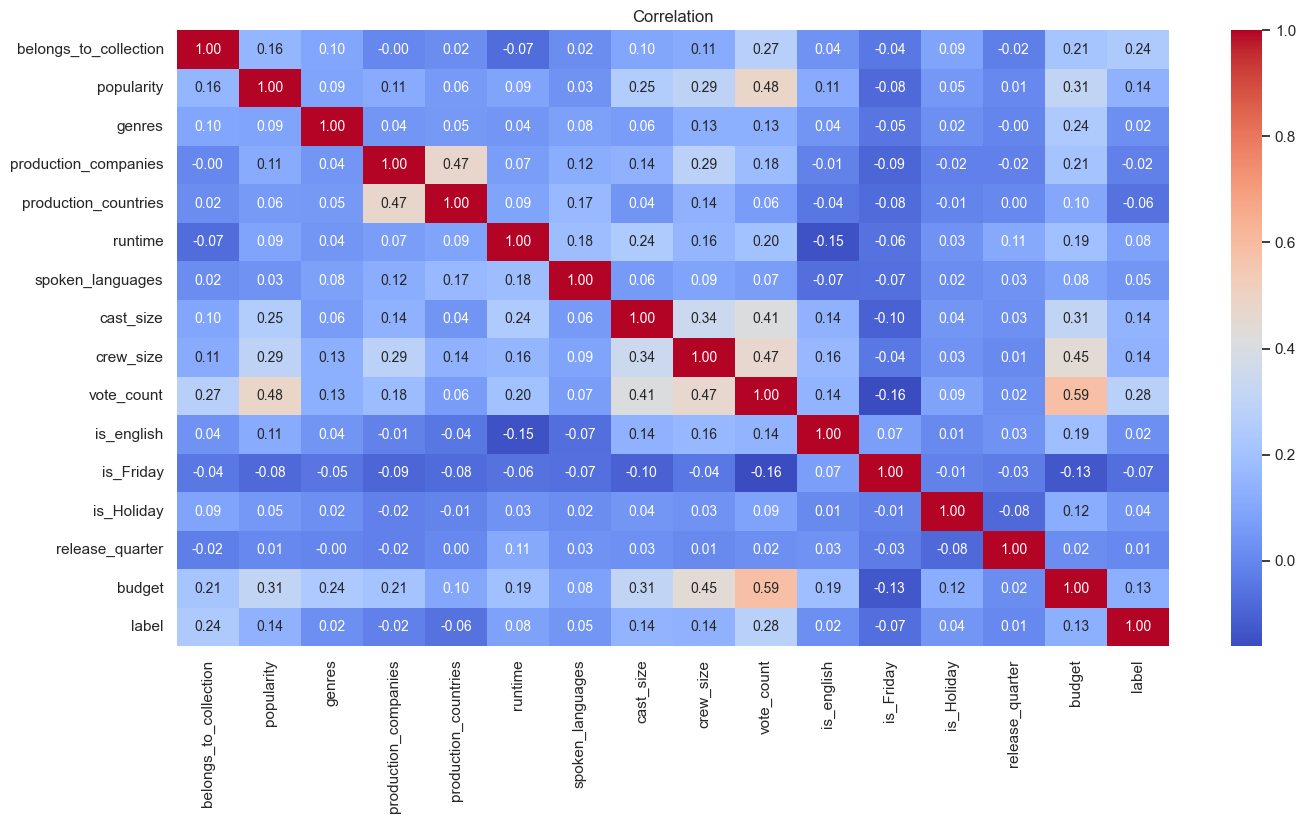

In [12]:
# heat map plot
plt.figure(figsize=(16,8))
plt.title("Correlation")
sns.heatmap(clean.corr(), annot=True, cmap="coolwarm", annot_kws={"fontsize": 10}, fmt=".2f")
plt.show()

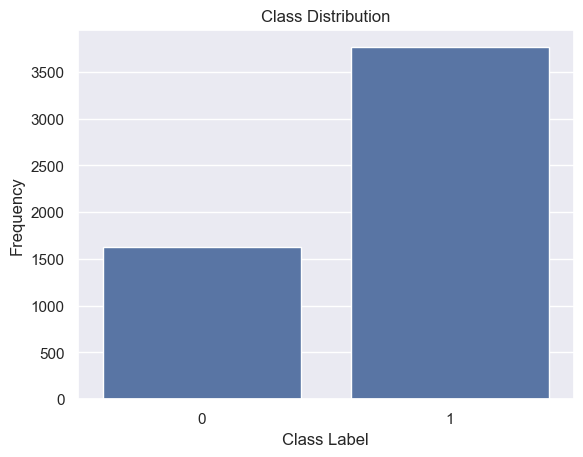

In [13]:
# label distribution plot
sns.countplot(clean, x='label')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()

# 4. DATA SPLIT

In [14]:
X = clean.drop('label', axis = 1)
y = clean.label

In [15]:
# split train & test using stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE)

print(f"Training Dataset Shape: {X_train.shape}")
print(f"Testing Dataset Shape:  {X_test.shape}")

Training Dataset Shape: (4314, 15)
Testing Dataset Shape:  (1079, 15)


In [16]:
# convert to array
X_train_arr = X_train.values
X_test_arr = X_test.values
y_train_arr = y_train.values.ravel()
y_test_arr = y_test.values.ravel()

In [17]:
# instantiate and fit scaler
scale = StandardScaler()
fit = scale.fit(X_train_arr)

# Transform original train and test sets
X_train_scaled = fit.transform(X_train_arr)
X_test_scaled = fit.transform(X_test_arr)

# 5. IMBALANCE HANDLING

In [18]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [19]:
# Over-sampling (SMOTE)
overSample = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE, k_neighbors=3)
X_over, y_over = overSample.fit_resample(X_train, y_train_arr)

In [20]:
# Under-sampling (RandomUnderSampler)
underSample = RandomUnderSampler(sampling_strategy='majority', random_state=RANDOM_STATE)
X_under, y_under = underSample.fit_resample(X_train, y_train_arr)

In [21]:
print("Over-sample shapes:", X_over.shape, y_over.shape, np.unique(y_over, return_counts=True))
print("Under-sample shapes:", X_under.shape, y_under.shape, np.unique(y_under, return_counts=True))

Over-sample shapes: (6022, 15) (6022,) (array([0, 1]), array([3011, 3011]))
Under-sample shapes: (2606, 15) (2606,) (array([0, 1]), array([1303, 1303]))


In [22]:
# Convert and Scale sampled data
X_over_arr = X_over.values
X_under_arr = X_under.values

In [23]:
# Scale the new sampled training sets
scale_over = StandardScaler()
X_over_scaled = scale_over.fit_transform(X_over_arr)

scale_under = StandardScaler()
X_under_scaled = scale_under.fit_transform(X_under_arr)

# 6. MODEL TRAINING

In [24]:
# Dictionary to store all fitted models for later comparison
fitted_models = {}

In [25]:
# Define the parameter grids for each model and scenario
rfc_param = {'random_state': RANDOM_STATE}
lr_param = {'random_state': RANDOM_STATE, 'solver': 'liblinear'}

model_configs = {
    "RandomForestClassifier": {
        "instance": RandomForestClassifier(**rfc_param),
        "params_Base": dict(
            min_samples_split = list(np.linspace(40, 70, num=4, dtype=np.intc)),
            max_depth = list(np.linspace(5, 9, num=3, dtype=np.intc)), 
            n_estimators = list(np.linspace(10, 125, num=4, dtype=np.intc)),
            criterion = ['gini', 'entropy'],
        ),
        "params_OverSample": dict(
            min_samples_split = list(np.linspace(30, 60, num=4, dtype=np.intc)),
            max_depth = list(np.linspace(6, 20, num=4, dtype=np.intc)), 
            n_estimators = list(np.linspace(10, 150, num=4, dtype=np.intc)),
            criterion = ['gini', 'entropy'],
        ),
        "params_UnderSample": dict(
            min_samples_split = list(np.linspace(15, 30, num=3, dtype=np.intc)),
            max_depth = list(np.linspace(6, 10, num=3, dtype=np.intc)), 
            n_estimators = list(np.linspace(50, 150, num=3, dtype=np.intc)),
            criterion = ['gini', 'entropy'],
        )
    },
    "LogisticRegression": {
        "instance": LogisticRegression(**lr_param),
        "params_Base": dict(
            C = np.round(np.linspace(0.15, 5, 15), 2),
            max_iter = list(np.linspace(50, 300, num=5, dtype=np.intc)),
            class_weight = ['balanced', None],
        ),
        "params_OverSample": dict(
            C = np.linspace(0.15, 5, 15),
            max_iter = list(np.linspace(50, 300, num=5, dtype=np.intc)),
            class_weight = ['balanced', None],
        ),
        "params_UnderSample": dict(
            C = np.round(np.linspace(0.15, 5, 15), 2),
            max_iter = list(np.linspace(50, 300, num=5, dtype=np.intc)),
            class_weight = ['balanced', None],
        )
    }
}

In [26]:
# Define the training scenarios
training_scenarios = [
    # (Scenario Name, X_train_data, y_train_data, X_test_data, y_test_data, param_key_suffix)
    ("Base", X_train_scaled, y_train_arr, X_test_scaled, y_test_arr, "Base"),
    ("OverSample", X_over_scaled, y_over, X_test_scaled, y_test_arr, "OverSample"),
    ("UnderSample", X_under_scaled, y_under, X_test_scaled, y_test_arr, "UnderSample")
]

In [27]:
# Training
for scenario_name, X_train_data, y_train_data, X_test_data, y_test_data, param_key in training_scenarios:
    
    for model_name, config in model_configs.items():
        
        # Create a unique identifier name
        ML_name = f"{model_name}-{scenario_name}" if scenario_name != "Base" else model_name
        
        print(f"\n--- Training: {ML_name} ---")
        
        # Get model, instance, and param grid
        model_instance = config["instance"]
        param_grid = config[f"params_{param_key}"]
        
        # Run GridSearch
        try:
            fit = kfold_grid(model_instance, param_grid, X_train_data, y_train_data)
            best_model = fit.best_estimator_
            print(f"\nBest Model: {best_model}\n")
            
            # Store the fitted model for later plotting
            fitted_models[ML_name] = best_model
            
            # Evaluate and store Metrics (using the adjusted function)
            df_ = classifier_performance_dict(
                ML_name, 
                best_model, 
                X_train_data, y_train_data,
                X_test_data, y_test_data
            )
            classify_performance_df = pd.concat([df_, classify_performance_df])
            
            print(f"--- Finished: {ML_name} ---")

        except Exception as e:
            print(f"!!! FAILED to train {ML_name}. Error: {e} !!!")

# Sort the main dataframe by index for comparison
classify_performance_df.sort_index(inplace=True)


--- Training: RandomForestClassifier ---
Starting GridSearchCV...
Evaluating best estimator with cross_val_score...
CV accuracy: 0.819 +/- 0.014

Best Model: RandomForestClassifier(criterion='entropy', max_depth=np.int32(9),
                       min_samples_split=np.int32(40),
                       n_estimators=np.int32(125), random_state=1776)

--- Finished: RandomForestClassifier ---

--- Training: LogisticRegression ---
Starting GridSearchCV...
Evaluating best estimator with cross_val_score...
CV accuracy: 0.809 +/- 0.014

Best Model: LogisticRegression(C=np.float64(4.31), max_iter=np.int32(50), random_state=1776,
                   solver='liblinear')

--- Finished: LogisticRegression ---

--- Training: RandomForestClassifier-OverSample ---
Starting GridSearchCV...
Evaluating best estimator with cross_val_score...
CV accuracy: 0.885 +/- 0.012

Best Model: RandomForestClassifier(criterion='entropy', max_depth=np.int32(20),
                       min_samples_split=np.int32(30),
 

# 7. FINAL EVALUATION AND COMPARISON

In [28]:
# Sort by algorithm name for consistent plotting
classify_performance_df.sort_index(inplace=True)
classify_performance_df.iloc[:, 2:]

,Recall(Sensitivity) Train,Specificity Train,Precision Train,Balanced Accuracy Train,F1 Train,Recall(Sensitivity) Test,Specificity Test,Precision Test,Balanced Accuracy Test,F1 Test
Algorithm,,,,,,,,,,
LogisticRegression,0.889406,0.465081,0.793481,0.677243,0.838710,0.880478,0.463190,0.791169,0.671834,0.833438
LogisticRegression-OverSample,0.673863,0.850548,0.818475,0.762205,0.739162,0.551129,0.855828,0.898268,0.703479,0.683128
LogisticRegression-UnderSample,0.620875,0.830391,0.785437,0.725633,0.693528,0.529880,0.883436,0.913043,0.706658,0.670588
RandomForestClassifier,0.947526,0.521873,0.820771,0.734699,0.879605,0.917663,0.371166,0.771205,0.644414,0.838084
RandomForestClassifier-OverSample,0.868482,0.910661,0.906727,0.889572,0.887193,0.675963,0.766871,0.870085,0.721417,0.760837
RandomForestClassifier-UnderSample,0.770530,0.885649,0.870772,0.828089,0.817590,0.579017,0.843558,0.895277,0.711288,0.703226



--- Base Model Performance ---


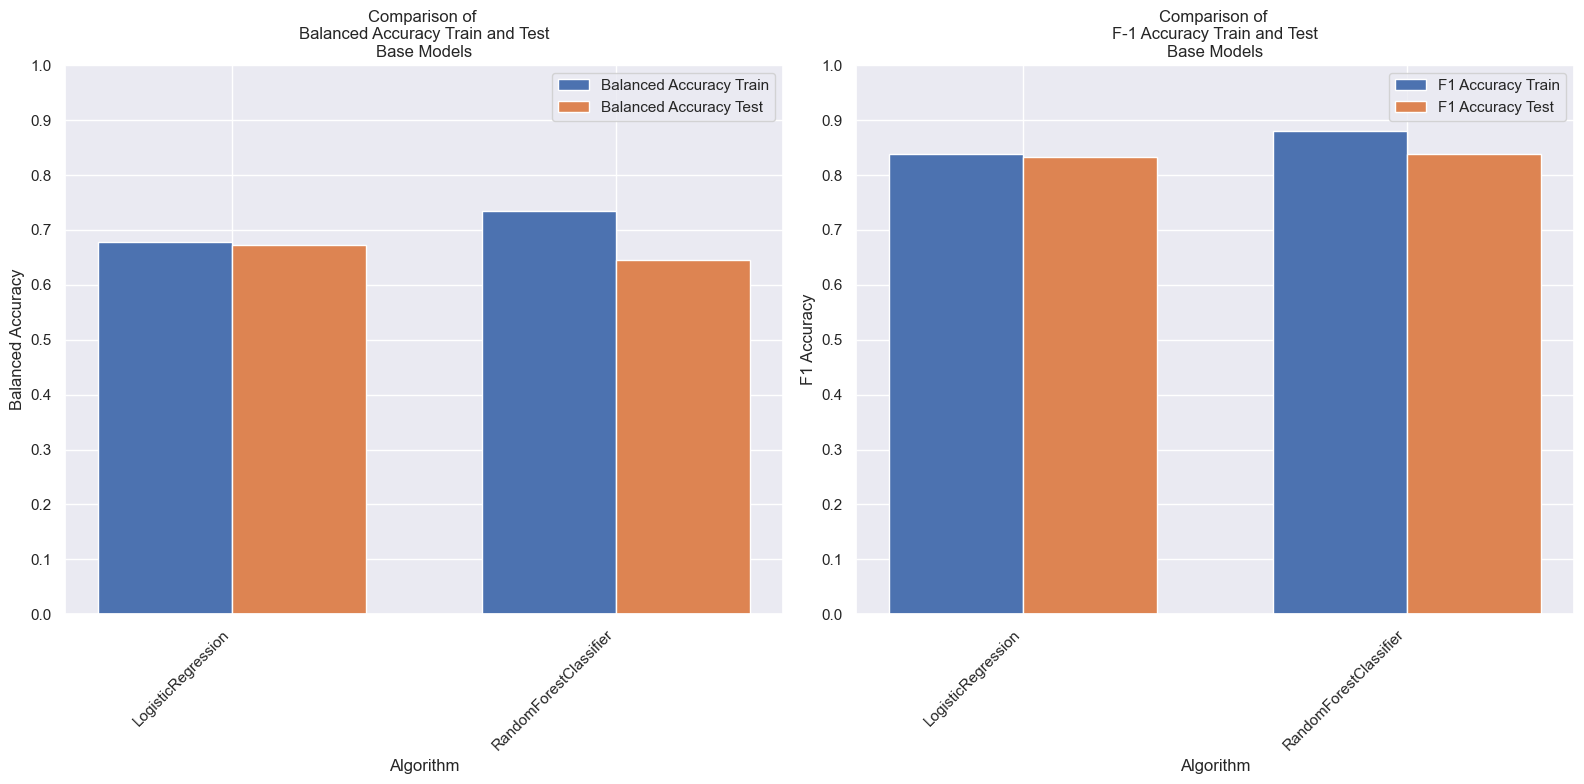


--- Over-Sampling Model Performance ---


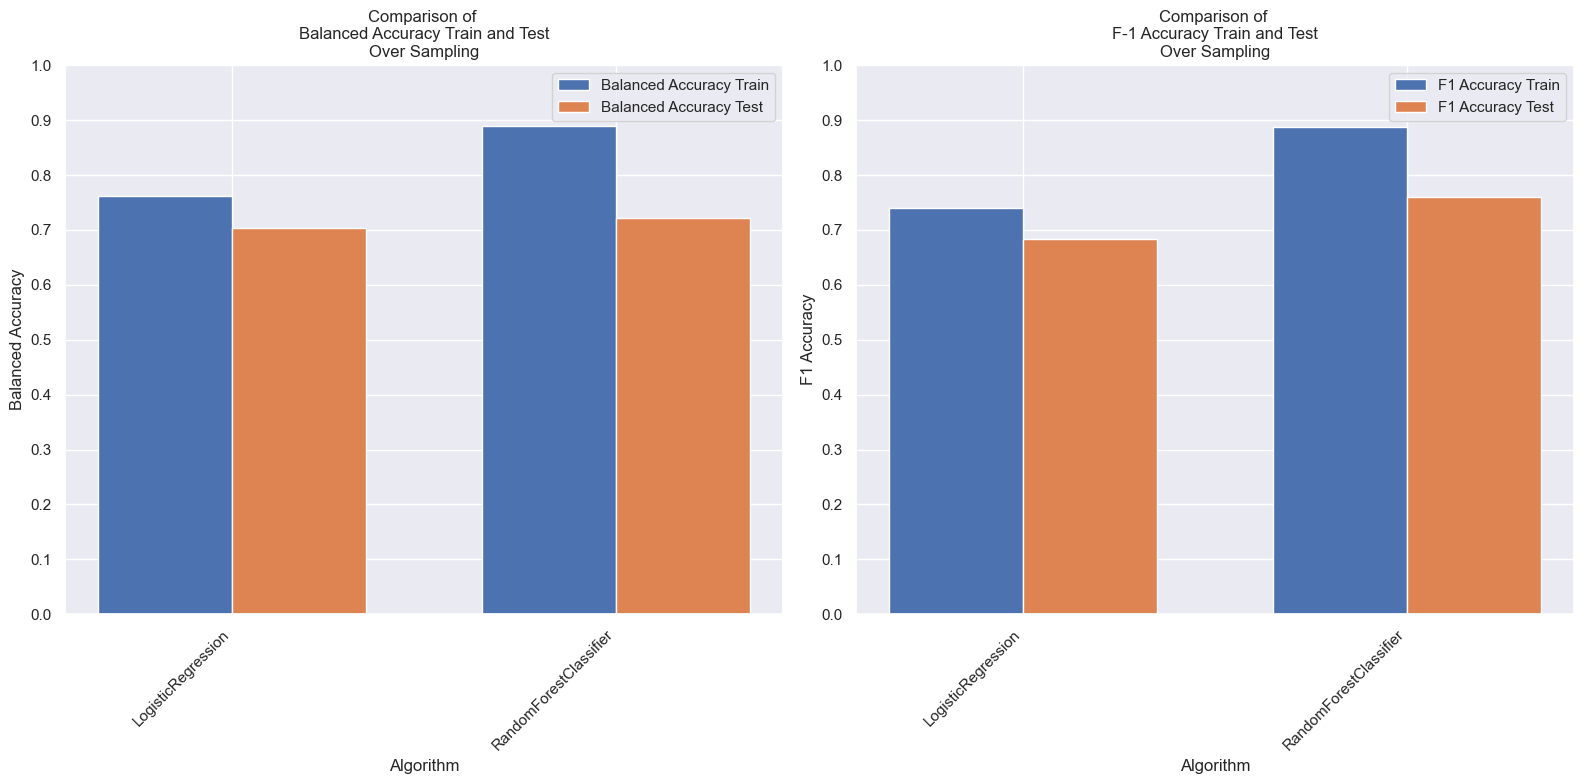


--- Under-Sampling Model Performance ---


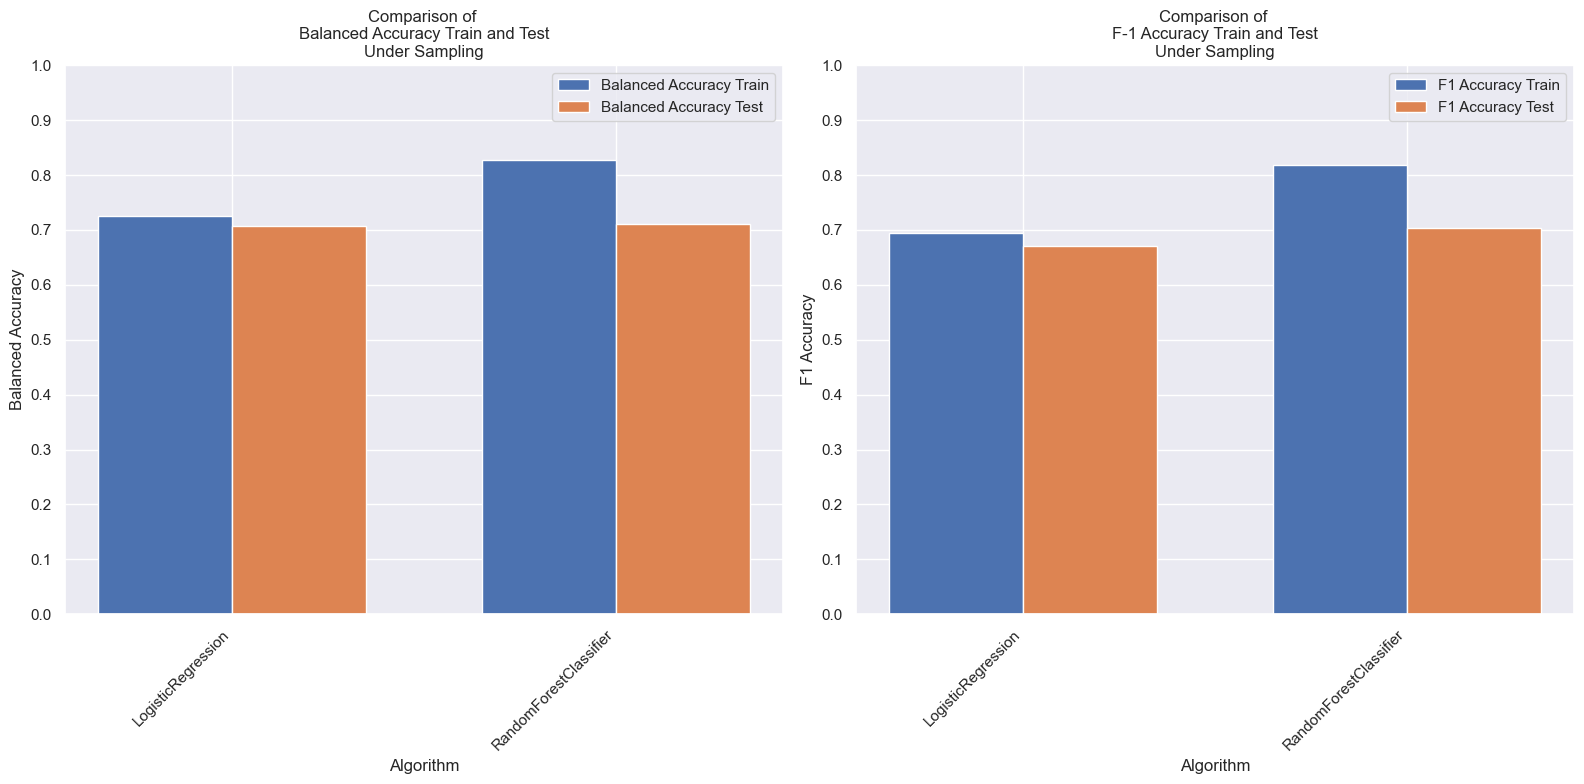

In [29]:
# Plot Bar charts for each scenario
print("\n--- Base Model Performance ---")
plotBar(classify_performance_df, stage=0)

print("\n--- Over-Sampling Model Performance ---")
plotBar(classify_performance_df, stage=2)

print("\n--- Under-Sampling Model Performance ---")
plotBar(classify_performance_df, stage=3)

--- Plotting Confusion Matrices (Train vs. Test) ---


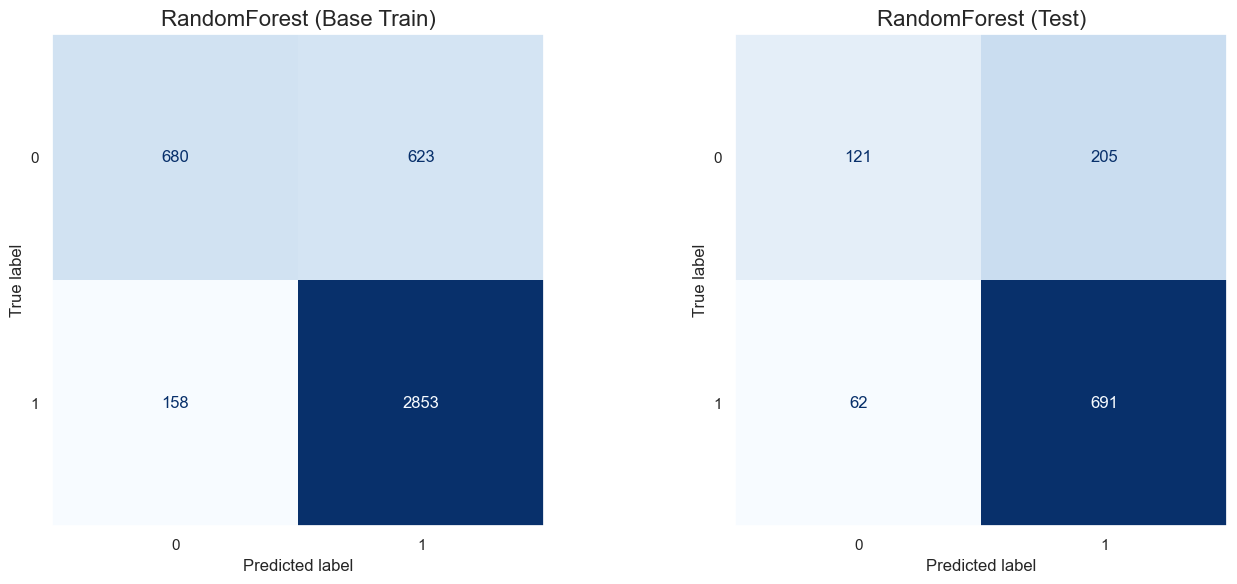

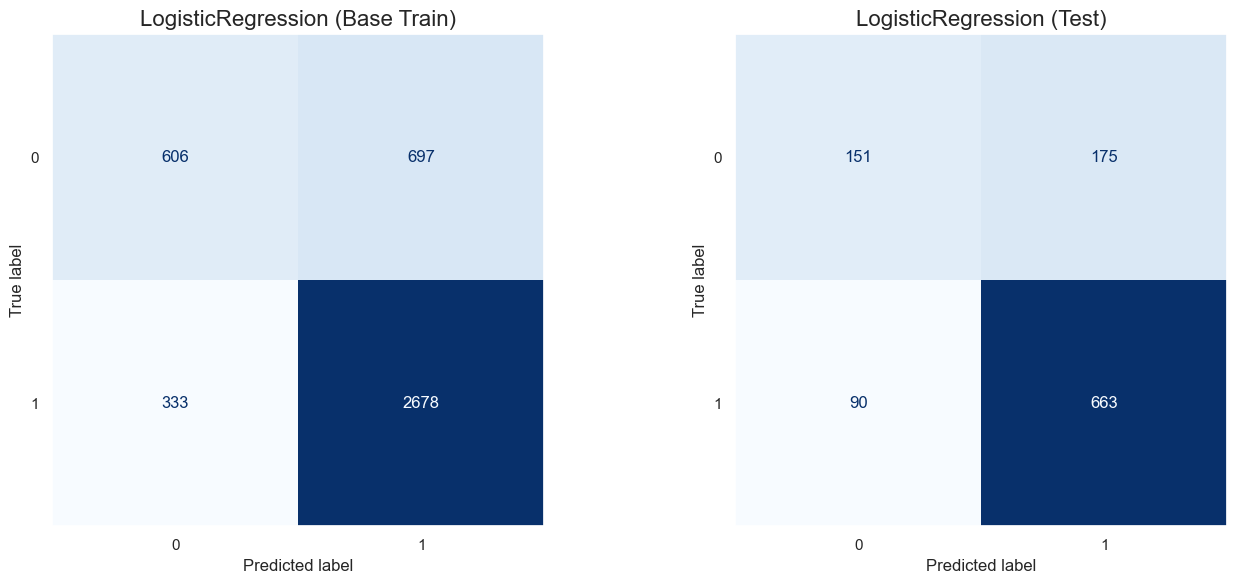

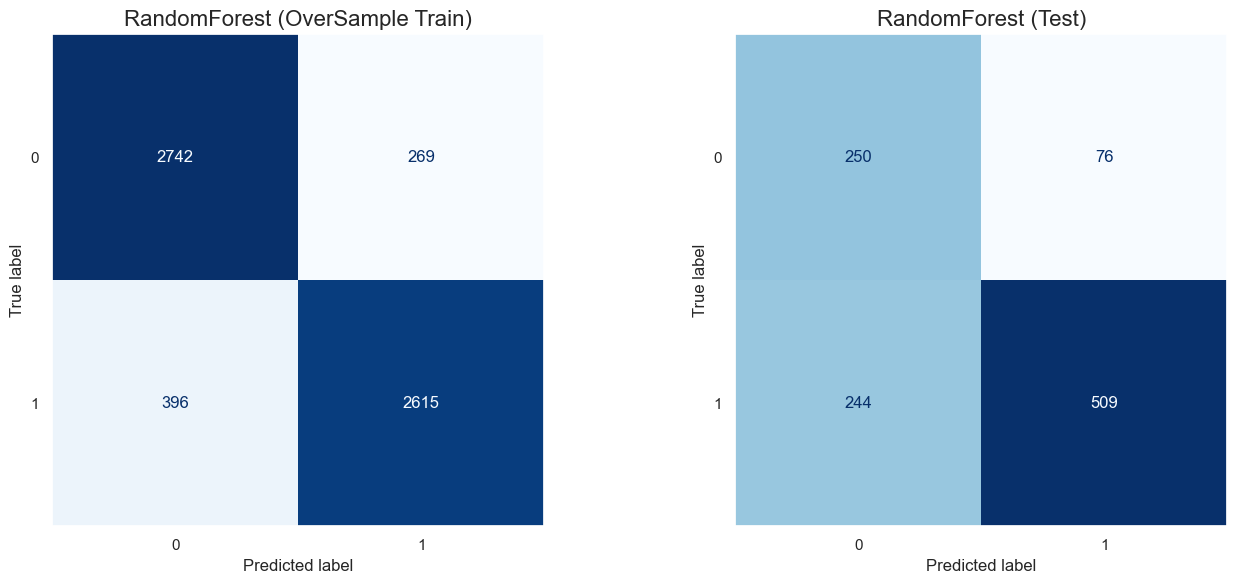

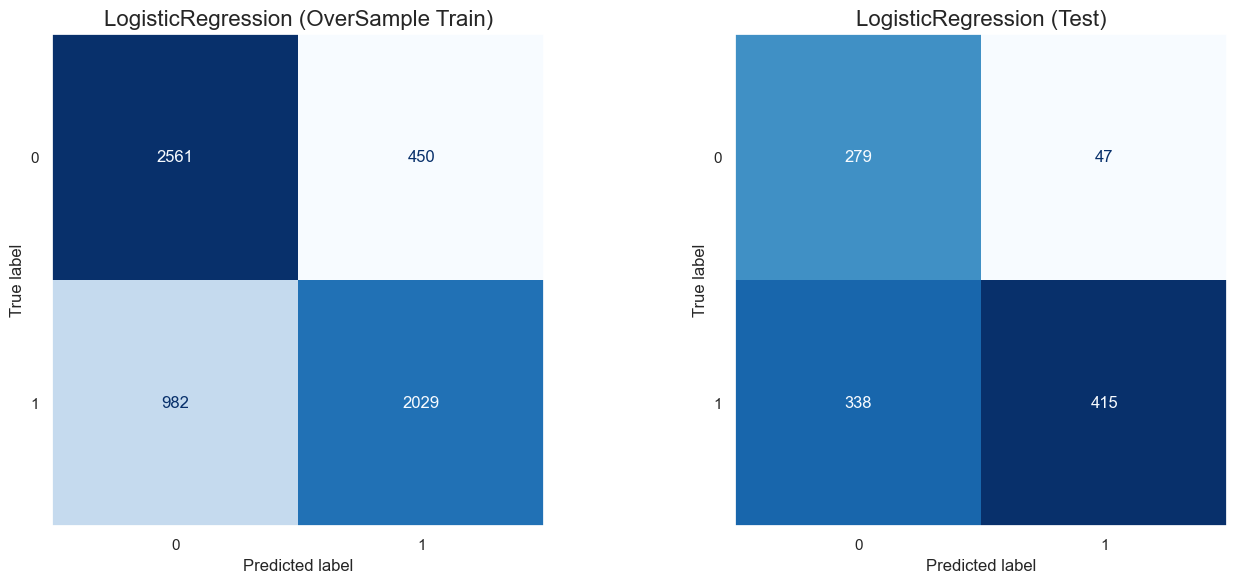

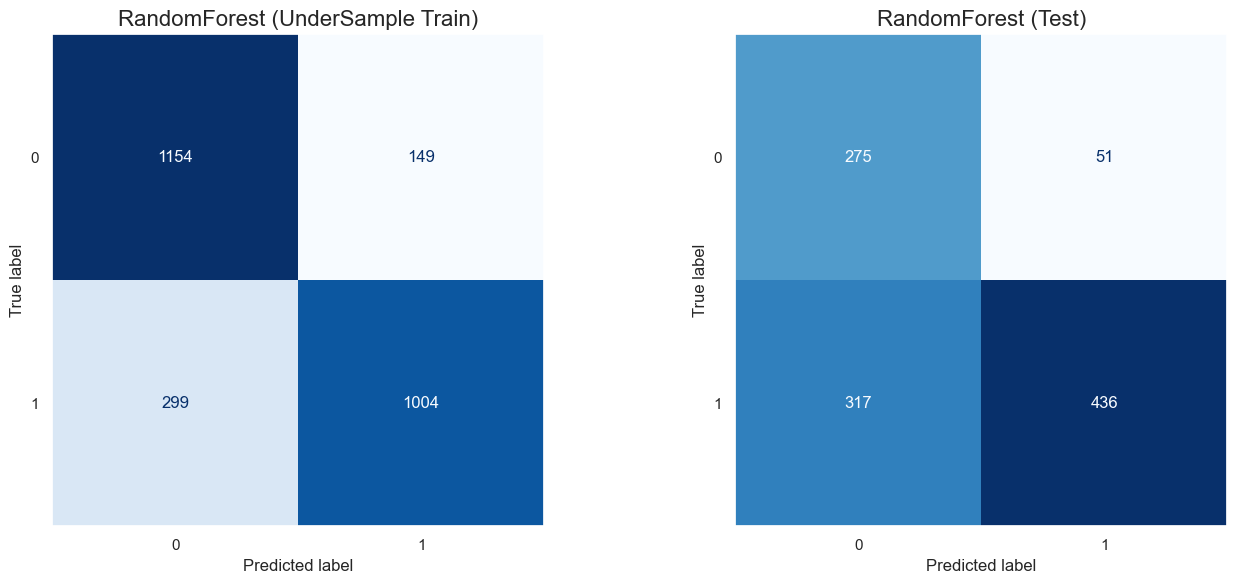

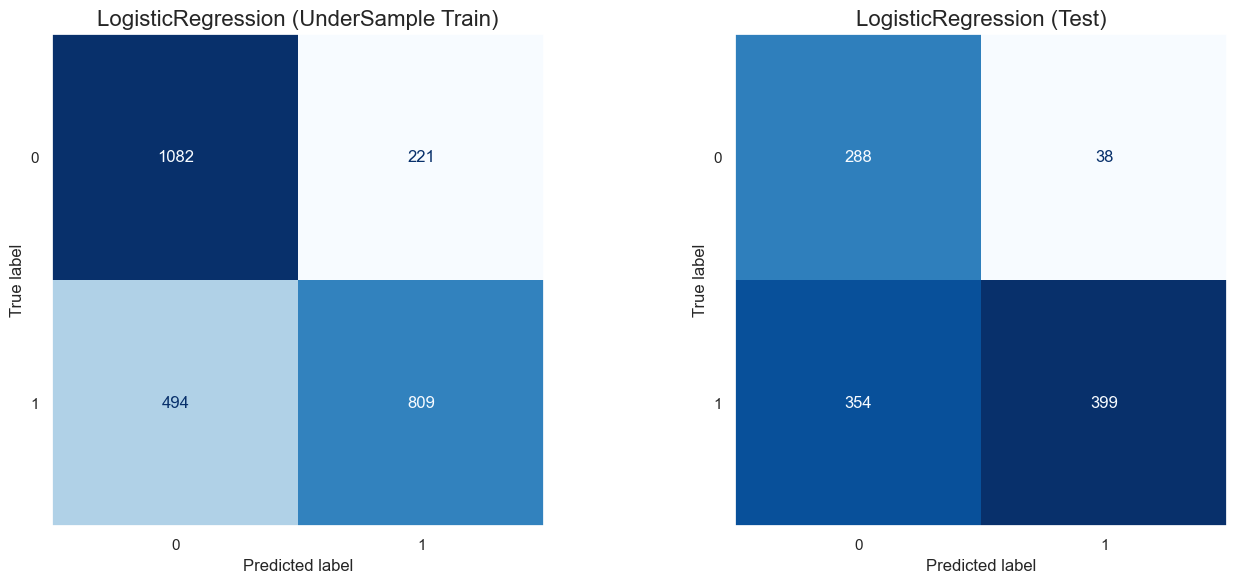

In [30]:
# Dictionary to map the correct dataset for each scenario
data_map = {
    "Base": (X_train_scaled, y_train_arr, X_test_scaled, y_test_arr),
    "OverSample": (X_over_scaled, y_over, X_test_scaled, y_test_arr),
    "UnderSample": (X_under_scaled, y_under, X_test_scaled, y_test_arr)
}

print("--- Plotting Confusion Matrices (Train vs. Test) ---")
for name, model in fitted_models.items():
    
    # Identify this model's scenario
    scenario_key = "Base"
    if "OverSample" in name:
        scenario_key = "OverSample"
    elif "UnderSample" in name:
        scenario_key = "UnderSample"
        
    # Get the corresponding data
    X_train_plot, y_train_plot, X_test_plot, y_test_plot = data_map[scenario_key]
    
    # Plot Confusion matrix
    plot_confusion_matrix(
        model, 
        X_train_plot, y_train_plot, 
        X_test_plot, y_test_plot,
        scenario_name=scenario_key
    )

--- Feature Importance ---

Feature Importance for: RandomForestClassifier
                       % Feature Importance
vote_count                        35.267469
popularity                        12.812353
budget                            10.216115
belongs_to_collection             10.119273
cast_size                          6.363221
runtime                            5.681130
crew_size                          5.472072
production_companies               4.341268
production_countries               3.085023
genres                             2.059827
spoken_languages                   1.390786
is_english                         1.246797
release_quarter                    0.956243
is_Friday                          0.541912
is_Holiday                         0.446513


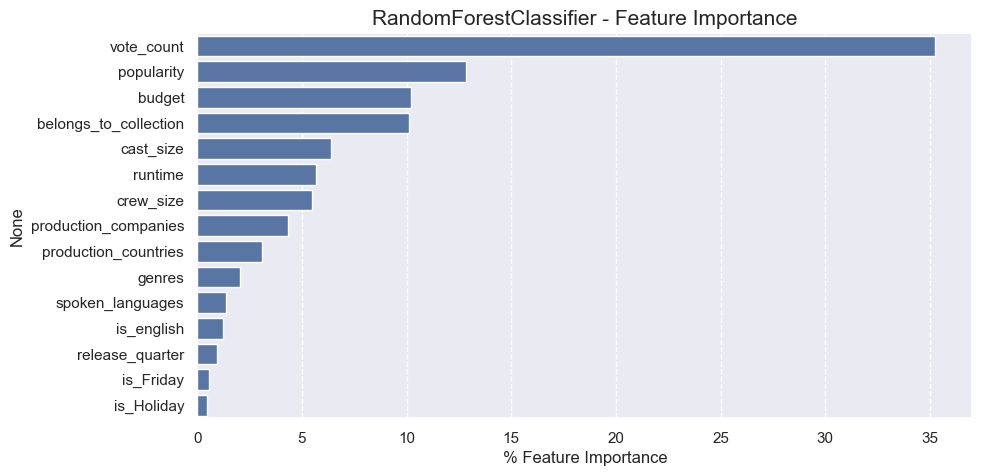


Feature Importance (Absolute Coefficient) for: LogisticRegression
                       % Feature Importance (Abs Coef)
vote_count                                  417.255825
budget                                       70.005791
belongs_to_collection                        50.585452
popularity                                   38.278075
production_companies                         29.005641
runtime                                      17.017127
production_countries                         15.187835
is_english                                   10.713387
spoken_languages                             10.506212
genres                                        6.967829
is_Holiday                                    4.112148
crew_size                                     4.086524
is_Friday                                     1.024642
cast_size                                     0.504971
release_quarter                               0.276065


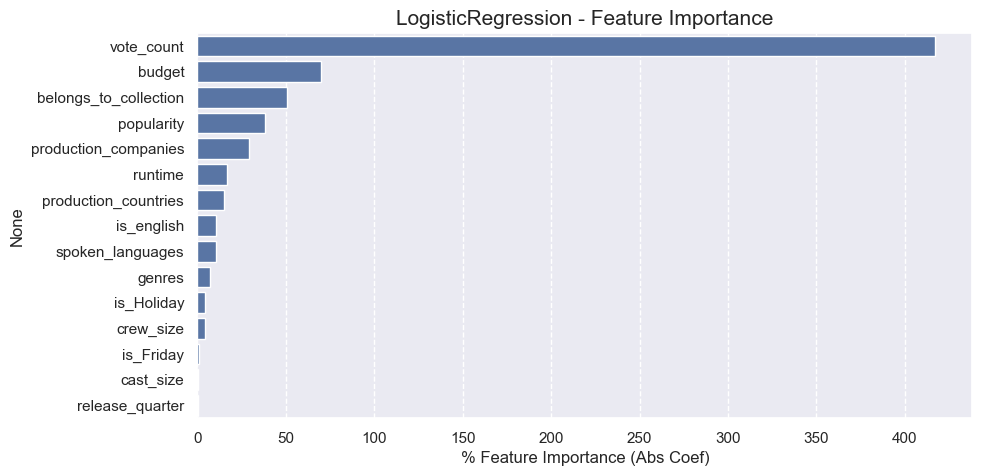


Feature Importance for: RandomForestClassifier-OverSample
                       % Feature Importance
vote_count                        27.590331
belongs_to_collection             11.821544
popularity                        11.274620
budget                            10.746502
runtime                            6.972185
cast_size                          6.147309
crew_size                          6.013590
release_quarter                    4.359667
production_companies               3.123840
is_Holiday                         2.990885
genres                             2.600695
spoken_languages                   2.279532
is_Friday                          1.598901
production_countries               1.555283
is_english                         0.925114


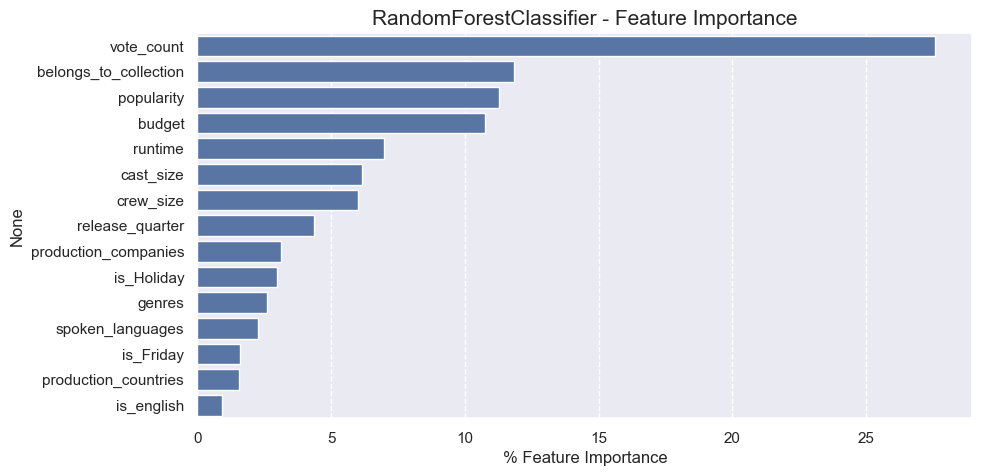


Feature Importance (Absolute Coefficient) for: LogisticRegression-OverSample
                       % Feature Importance (Abs Coef)
vote_count                                  393.485150
budget                                       80.566934
belongs_to_collection                        70.637497
is_Holiday                                   30.941051
is_Friday                                    25.639462
spoken_languages                             25.558656
production_companies                         22.872522
runtime                                      19.286999
release_quarter                              18.868540
crew_size                                    12.266470
popularity                                   11.615173
genres                                       10.673417
is_english                                    5.103695
cast_size                                     2.453744
production_countries                          2.413604


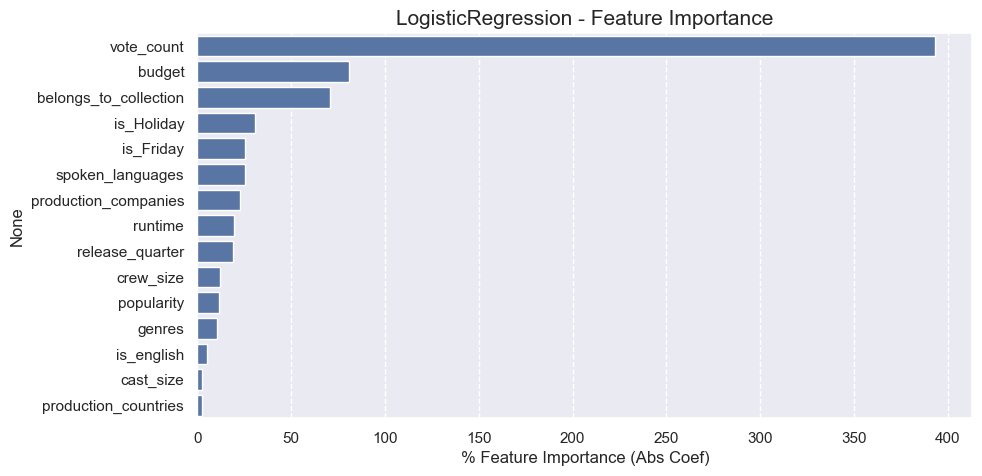


Feature Importance for: RandomForestClassifier-UnderSample
                       % Feature Importance
vote_count                        32.411998
popularity                        12.375868
budget                            10.296890
belongs_to_collection              9.521426
runtime                            6.753798
cast_size                          6.753584
crew_size                          6.532373
production_companies               4.284078
production_countries               2.740401
genres                             2.337479
spoken_languages                   2.080440
release_quarter                    1.422510
is_english                         1.149213
is_Friday                          0.757023
is_Holiday                         0.582921


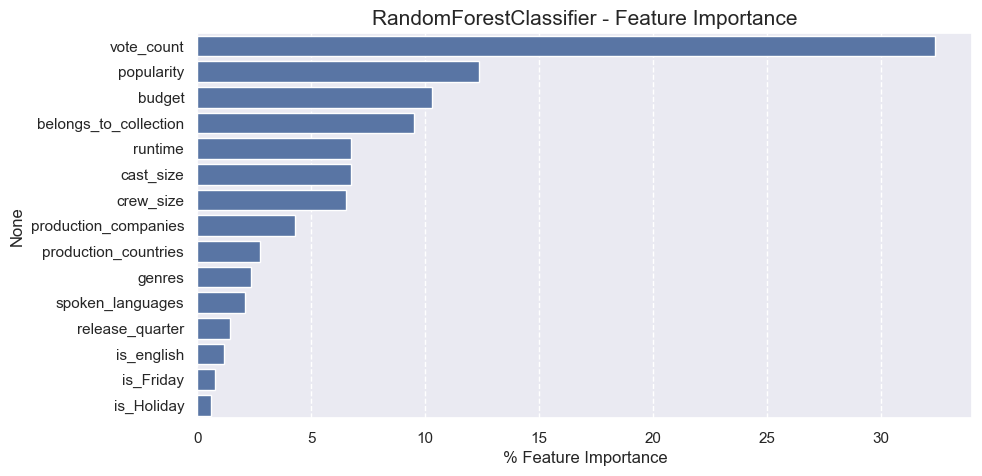


Feature Importance (Absolute Coefficient) for: LogisticRegression-UnderSample
                       % Feature Importance (Abs Coef)
vote_count                                  325.288997
budget                                       58.577462
belongs_to_collection                        50.498704
production_companies                         29.691818
popularity                                   24.901243
production_countries                         17.833624
runtime                                      16.273515
spoken_languages                             12.685164
is_english                                    7.647351
genres                                        5.843332
cast_size                                     3.993876
crew_size                                     3.578789
is_Holiday                                    2.749793
release_quarter                               2.541409
is_Friday                                     1.530113


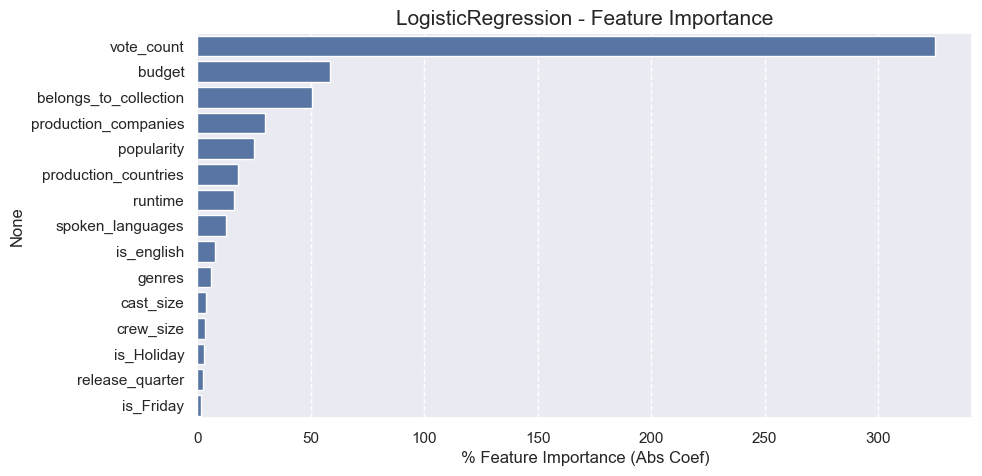

In [31]:
# Feature Importance
print("--- Feature Importance ---")
for name, model in fitted_models.items():
    if "RandomForest" in name:
        print(f"\nFeature Importance for: {name}")
        plot_feature_importance(model, X)
    elif "LogisticRegression" in name:
        print(f"\nFeature Importance (Absolute Coefficient) for: {name}")
        plot_feature_importance(model, X)

											Model=RandomForestClassifier Best Threshold=0.510, F-Score=0.843
											Model=LogisticRegression Best Threshold=0.475, F-Score=0.848
											Model=RandomForestClassifier-OverSample Best Threshold=0.236, F-Score=0.832
											Model=LogisticRegression-OverSample Best Threshold=0.171, F-Score=0.834
											Model=RandomForestClassifier-UnderSample Best Threshold=0.268, F-Score=0.840
											Model=LogisticRegression-UnderSample Best Threshold=0.219, F-Score=0.846


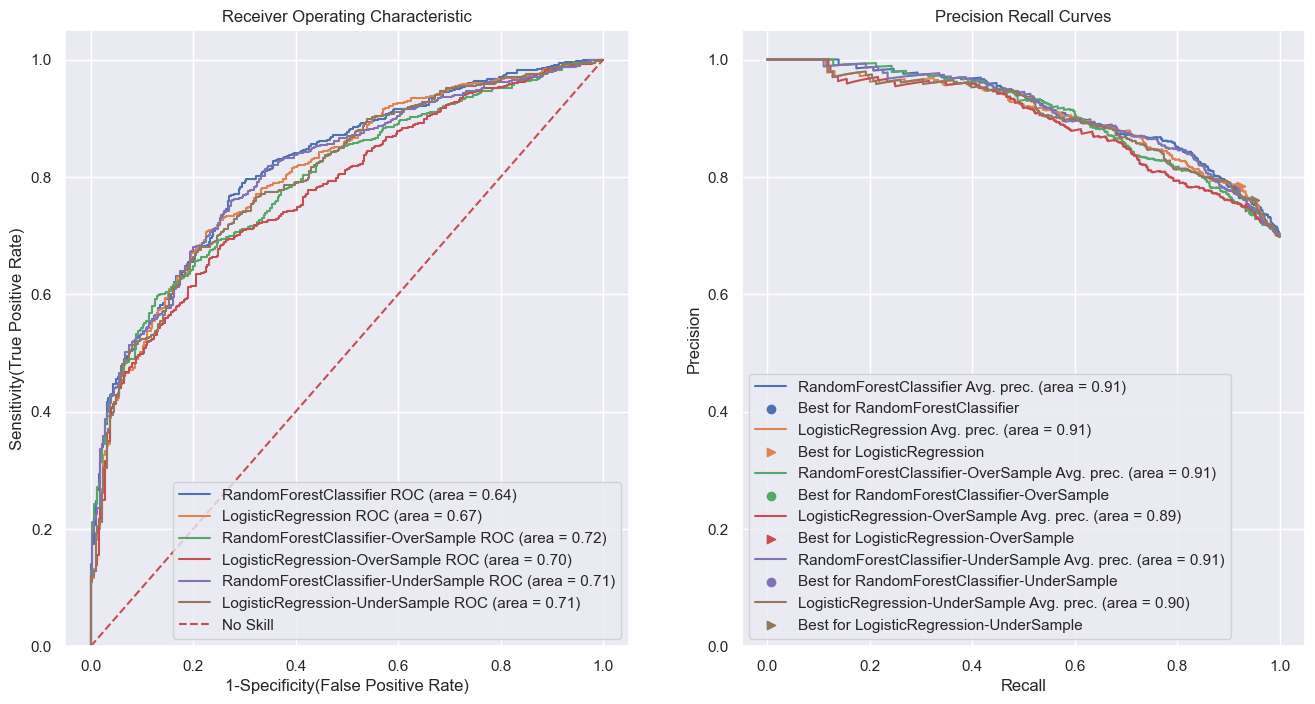

In [32]:
# Plot ROC/PR curves for all models on one chart for comparison
models_curve_all = []
for name, model in fitted_models.items():
    if "RandomForest" in name:
        marker = 'o'
    elif "Logistic" in name:
        marker = '>'
    else:
        marker = 'x'
    
    models_curve_all.append({
        'label': name,
        'marker': marker,
        'model': model
    })

Curve(models_curve_all, X_test_scaled, y_test_arr)